# Plotting exploitable biomass estimated by DBPM
**Author**: Denisse Fierro Arcos  
**Date**: 2025-02-06  

## Loading relevant libraries

In [2]:
import os
os.chdir('/g/data/vf71/la6889/dbpm_southern_ocean/scripts/')
from glob import glob
import xarray as xr
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as PathEffects
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client

## Start a cluster for parallelisation

In [2]:
client = Client(threads_per_worker = 1, memory_limit = 0)

## Defining basic variables to run gridded DBPM

In [22]:
#Name of region and model resolution
region = 'fao-48'
reg_name = 'weddell'
model_res = '1deg'
runs = '_simask'

# Paths to input and output folders
base_folder = f'/g/data/vf71/la6889/dbpm_inputs/{reg_name}'
gridded_inputs = os.path.join(base_folder, 'gridded_params', model_res)
gridded_outputs_old_eff = os.path.join(base_folder, 'run_fishing', model_res)
gridded_outputs_new_eff = os.path.join(base_folder, 'run_fishing_new_eff', model_res)
gridded_outputs_seaice = os.path.join(base_folder, 'gridded_dbpm_outputs_seaicemask', model_res)
outputs_folder = os.path.join(base_folder, 'gridded_dbpm_outputs', model_res)

## Loading area file to create mask for region

In [23]:
mask = xr.open_zarr(glob(os.path.join(base_folder, 'gridded', model_res, 
                                      '*areacello*'))[0])['cellareao']
mask = xr.where(np.isfinite(mask), 1, np.nan)

In [24]:
# Getting longitude for filtering
if mask.lon.max() > 180:
    lon_filter = ((mask.lon+180)%360)-180
else:
    lon_filter = mask.lon

## Loading sea ice data
Calculate mean sea ice cover per year and identify the edge of the sea ice, which is defined as the grid cells where sea ice concentration is 15\%.

In [3]:
si_yr = xr.open_dataarray(os.path.join(
    base_folder, 'gridded', model_res,
    f'gfdl-mom6-cobalt2_obsclim_siconc_{model_res}_{region}_yearly_1961_2010.nc'))
sie = xr.open_dataarray(os.path.join(
    base_folder, 'gridded', model_res, 
    f'sie_obsclim_{model_res}_{region}_yearly_1961_2010.nc'))

## Loading total catches estimated by DBPM

In [24]:
# Load estimated catches
total_catch = xr.open_zarr(glob(
    os.path.join(outputs_folder, f'total_catches{runs}_{model_res}_*'))[0])['total_catches']

# Calculate mean catches per year - Model period only (1961-2010)
total_catch_sub = total_catch.sel(time = slice('1961', None))

## Monthly means for catches

In [7]:
si_month = si.groupby('time.month').mean('time')
si_month = xr.where(si_month >= 15, 1, 0).load()

In [12]:
si_month = si_month.sel(lat = mask.lat, lon = lon_filter)

#If mask longitude in 0-360, then apply the same to SIC data
if mask.lon.max() > 180:
    si_month['lon'] = si_month.lon%360
    si_month = si_month.sortby('lon')*mask

In [16]:
#Calculate average SIC per year
sie_mean = sie_mean_globe.sel(lat = mask.lat, lon = lon_filter)

#If mask longitude in 0-360, then apply the same to SIC data
if mask.lon.max() > 180:
    sie_mean['lon'] = sie_mean.lon%360
    sie_mean = sie_mean.sortby('lon')*mask

## Total exploitable biomass

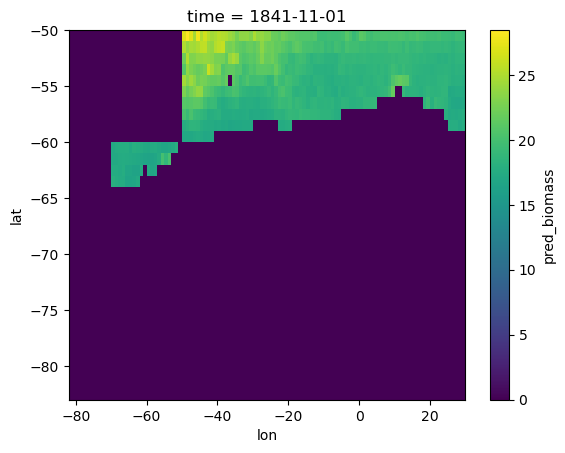

In [36]:
predators.isel(time = 10).sum('size_class').plot()

In [39]:
outputs_folder

'/g/data/vf71/la6889/dbpm_inputs/weddell/gridded_dbpm_outputs/1deg'

In [83]:
ds = xr.open_mfdataset(glob('/g/data/vf71/la6889/dbpm_inputs/weddell/run_fishing_seaicemask/1deg/detritivores*184*.nc'))['detritivores']

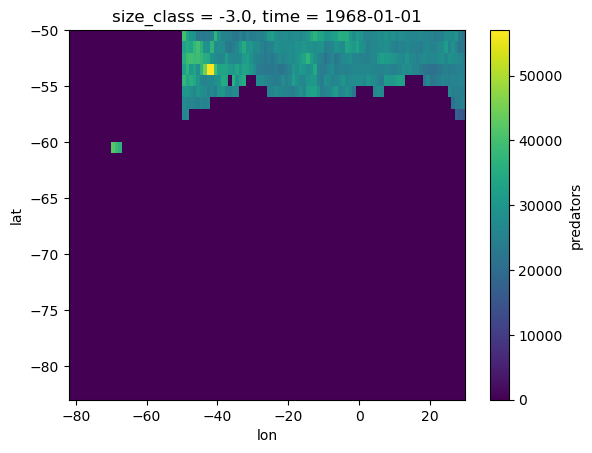

In [62]:
# test = ds.sel(time = '1968-01').isel(size_class = 90)
(xr.where(np.isfinite(test), test, 0)).plot()

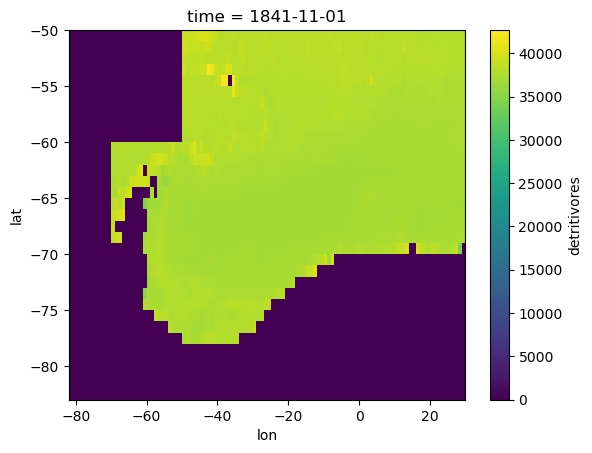

In [84]:
ds.sel(time = '1841-11').sum('size_class').plot()

In [25]:
#Loading predators
predators = xr.open_mfdataset(glob(
    os.path.join(outputs_folder, f'pred_bio*{runs}*1841*')))['pred_biomass']

#Loading detritivores
detritivores = xr.open_mfdataset(glob(
    os.path.join(outputs_folder, f'detriti_bio*{runs}*1841*')))['detriti_biomass']

#Size class bins
log10_size_bins_mat = xr.open_zarr('../outputs/log10_size_bins_matrix.zarr/')['size_bins']
size_bin_vals = 10**log10_size_bins_mat

#Model parameters
gridded_params = json.load(open(
    os.path.join(gridded_inputs, f'dbpm_gridded_size_params_{region}_python.json')))

In [26]:
pred_exp = (predators.sel(time = slice('1961', None)).
    sel(size_class = slice(size_bin_vals[gridded_params['ind_min_fish_pred']], None)).
    sum('size_class'))

det_exp = (detritivores.sel(time = slice('1961', None)).
    sel(size_class = slice(size_bin_vals[gridded_params['ind_min_fish_det']], None)).
    sum('size_class'))

tot_exp = pred_exp+det_exp
tot_exp.name = 'total_exploitable_biomass'

### Calculate mean over entire model period 

In [27]:
total_exp_sub = (tot_exp.mean('time')*mask).load()

### Merging means for all regions 

Initialising empty dictionary to store catches and sea ice information for all regions.

In [11]:
tot_exp_all = {}

Adding data for each region into dictionary.

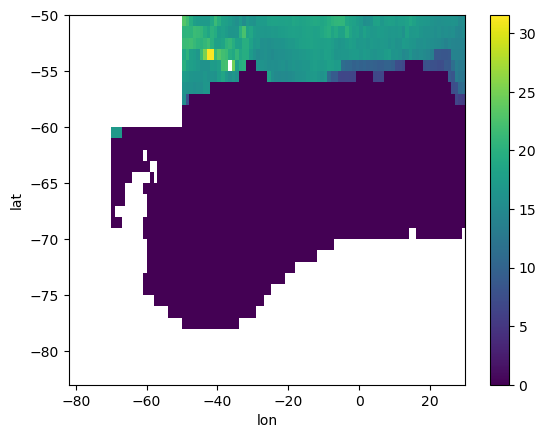

In [28]:
total_exp_sub.plot()

In [29]:
tot_exp_all[region] = total_exp_sub

In [30]:
tot_exp_all = xr.Dataset(tot_exp_all)
tot_exp_all = tot_exp_all.chunk({'lat': -1, 'lon': -1})

Saving results for future reference.

In [31]:
tot_exp_all.to_zarr(
    os.path.join('../data', f'mean_tot-exp-bio_all_regions{runs}_{model_res}_1961-2010.zarr'),
consolidated = True, mode = 'w')

### **Optional:** Loading exploitable biomass

In [20]:
model_res = '1deg'

In [21]:
tot_exp_all = xr.open_zarr(
    os.path.join('../data', f'mean_tot-exp-bio_all_regions{runs}_{model_res}_1961-2010.zarr'))

## Plotting mean total exploitable biomass

In [50]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                               facecolor = 'gray', linewidth = 0.5)

## Composite maps - all regions, mutiple decades

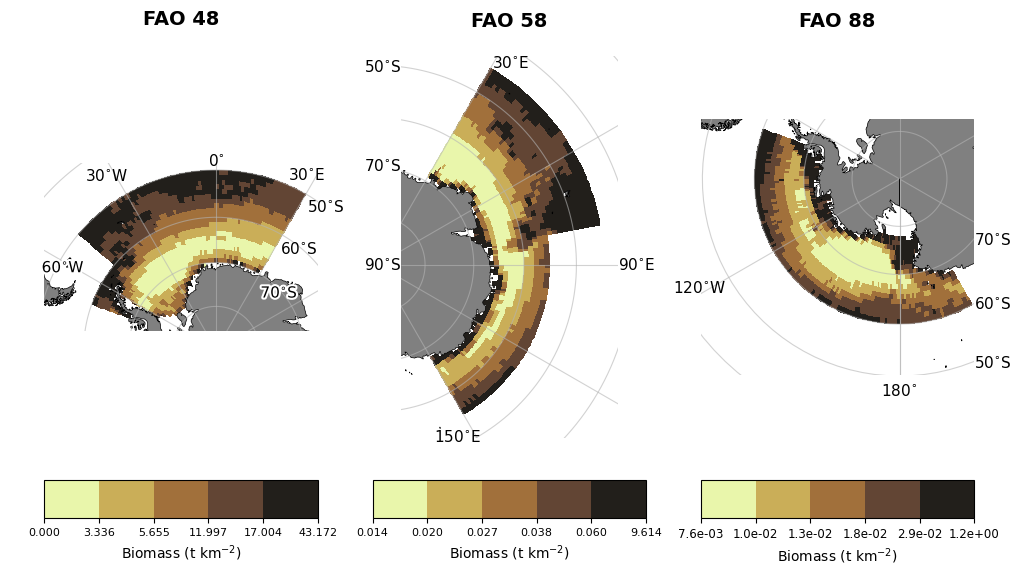

In [22]:
fig = plt.figure(figsize = (12, 6))

fao_reg = sorted(list(tot_exp_all.keys()))

gs = gridspec.GridSpec(nrows = 2, ncols = 3, height_ratios = (1, 0.1))

ax = {}
plots = {}
for i, r in enumerate(fao_reg):
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    da = tot_exp_all[r]
    levels = da.quantile(np.arange(0, 1.1, 0.2)).values
    plots[r] = da.plot(levels = levels, ax = ax[i], cmap = cm.cm.turbid,
                       add_colorbar = False, transform = ccrs.PlateCarree())
    ax[i].add_feature(land_50m)
    #Customise area shown in the maps
    coord_lab = 11
    if r == 'fao-48':
        ax[i].text(0.5, 1.85, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([-65, 32.5, -80, -48], crs = ccrs.PlateCarree())
        plt.text(0.15, 0.89, '$30^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.01, 0.35, '$60^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab, 
                 path_effects = [PathEffects.withStroke(linewidth = 3, foreground = 'w')])
        plt.text(0.60, 0.98, '$0^{\circ}$', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.89, 0.9, '$30^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.79, 0.2, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab,
                 path_effects = [PathEffects.withStroke(linewidth = 3, foreground = 'w')])
        plt.text(0.86, 0.46, '$60^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.96, 0.71, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    elif r == 'fao-58':
        ax[i].text(0.5, 1.09, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([30, 136, -80, -42.5], crs = ccrs.PlateCarree())
        plt.text(-0.17, 0.96, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.17, 0.7, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.17, 0.44, '$90^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.42, 0.97, '$30^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.44, '$90^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.15, -0.01, '$150^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    else:
        ax[i].text(0.5, 1.38, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([158, 287.5, -80, -49.5], crs = ccrs.PlateCarree())
        plt.text(1, 0.51, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.26, '$60^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.03, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.1, 0.32, '$120^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.66, -0.08, '$180^{\circ}$', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    
    ax[i].set_title('')
        
    #Remove border around map
    [s.set_visible(False) for s in ax[i].spines.values()]
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                         color = "#b4b4b4", alpha = 0.6)
    # #Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}

cbar = fig.colorbar(plots['fao-48'], cax = plt.subplot(gs[3]), 
                    orientation = 'horizontal', pad = 0.075, format = '%.3f')
cbar.set_label('Biomass (t km$^{-2}$)', y = .95)
cbar.ax.tick_params(labelsize = 8)
cbar = fig.colorbar(plots['fao-58'], cax = plt.subplot(gs[4]), 
                    orientation = 'horizontal', pad = 0.075)
cbar.ax.tick_params(labelsize = 8)
cbar.set_label('Biomass (t km$^{-2}$)', y = .95)
cbar = fig.colorbar(plots['fao-88'], cax = plt.subplot(gs[5]), 
                    orientation = 'horizontal', pad = 0.075, format = '%4.1e')
cbar.set_label('Biomass (t km$^{-2}$)', y = .95)
cbar.ax.tick_params(labelsize = 8.5)

fout = os.path.join('../outputs', f'mean_tot-exp-bio_all_regions{runs}_{model_res}.png')
plt.savefig(fout, dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)